# Variational Quantum Eigensolver - Ground State Energy for $LiH$ Molecule using the RY ansatz

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

Backend

In [3]:
qasm_sim = QasmSimulator()
state_sim = StatevectorSimulator()

Drivers

Below we set up a PySCF driver for LIH molecule at equilibrium bond length 1.5474 Angstrom

In [4]:
def exact_diagonalizer(es_problem, qubit_converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(qubit_converter, solver)
    result = calc.solve(es_problem)
    return result

In [5]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [6]:
def initial_state_preparation(mapper_str: str = "jw"):
    
    molecule = "Li 0.0 0.0 0.0; H 0.0 0.0 1.5474"
    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [7]:
qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation("pa")

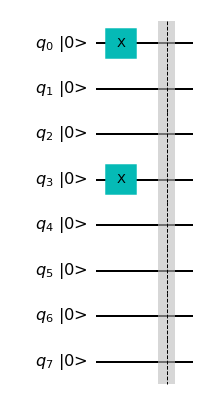

In [18]:
init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

init_state.barrier()

init_state.draw("mpl", initial_state=True).savefig("ry_vqe_lih_init_state.png", dpi=300)
init_state.draw("mpl", initial_state=True)

In [21]:
# Setting up TwoLocal for our ansatz
ansatz_type = "RY"

# Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ["ry"]
# Entangling gates
entanglement_blocks = "cx"
# How the qubits are entangled?
entanglement = 'linear'
# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 1
# Skipoing the final rotation_blocks layer
skip_final_rotation_layer = False

ansatz = TwoLocal(
    qubit_op.num_qubits,
    rotation_blocks,
    entanglement_blocks,
    reps=repetitions,
    entanglement=entanglement,
    skip_final_rotation_layer=skip_final_rotation_layer,
    # insert_barriers=True
)

# Add the initial state
ansatz.compose(init_state, front=True, inplace=True)    

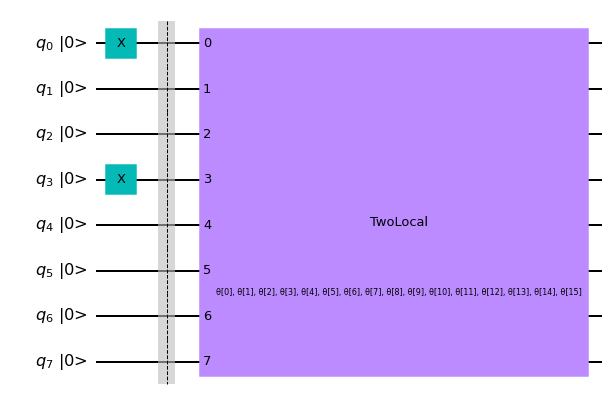

In [22]:
ansatz.draw(output="mpl", initial_state=True).savefig("ry_vqe_lih_ansatz.png", dpi=300)

ansatz.draw(output="mpl", initial_state=True)

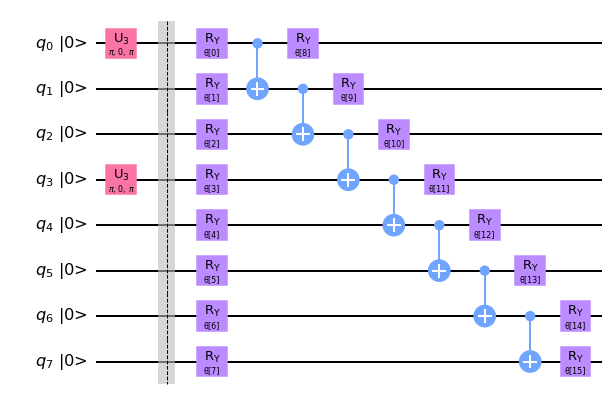

In [23]:
ansatz.decompose().draw(output="mpl", initial_state=True).savefig("ry_vqe_lih_ansatz_decomposed.png", dpi=300)

ansatz.decompose().draw(output="mpl", initial_state=True)

In [12]:
optimizer = COBYLA(maxiter=10000)

## Solver

### Exact Eigensolver using NumPyMinimumEigensolver

In [13]:
result_exact = exact_diagonalizer(es_problem, qubit_converter)
exact_energy = np.real(result_exact.eigenenergies[0])

print("Exact Electronic Energy: {:.4f} Eh\n\n".format(exact_energy))

print("Results:\n\n", result_exact)

Exact Electronic Energy: -8.9087 Eh


Results:

 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.908697116424
  - computed part:      -8.908697116424
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.882762236781
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 


### VQE Solver

In [14]:

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# we choose a fixed small displacement

try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters
    
algorithm = VQE(
    ansatz,
    optimizer=optimizer,
    quantum_instance=state_sim,
    callback=callback,
    initial_point=initial_point
)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 2288,
    'eigenstate': array([ 4.17541727e-08-1.47826751e-21j, -6.08978182e-05+3.04430835e-22j,
       -2.06912153e-09+8.47454827e-22j,  3.50174240e-05-1.74522798e-22j,
        3.76085218e-08-6.90758373e-21j, -2.85325448e-04+1.42253109e-21j,
       -2.66845151e-07-3.23121507e-21j, -1.34850125e-04+6.65428616e-22j,
       -9.06850237e-05+1.50590930e-17j,  6.21990402e-01-3.10123318e-18j,
        5.67545519e-04+6.64729135e-18j,  2.77505431e-01-1.36892710e-18j,
       -7.16666942e-05+8.52060183e-21j,  4.17620536e-06-1.75471213e-21j,
       -1.16618395e-04-3.26609779e-18j, -1.35562439e-01+6.72612279e-19j,
        1.27662106e-08-3.16630074e-21j, -1.30809302e-04+6.52060317e-22j,
       -1.29620131e-07-1.68534725e-21j, -7.02891187e-05+3.47076336e-22j,
        9.20450969e-09+1.32293082e-21j,  5.47248034e-05-2.72441173e-22j,
        7.78969117e-08+1.36796965e-21j,  5.69199328e-05-2.81716362e-22j,
        1.73933883e-05-2.88833540e-

In [15]:
# Storing results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
# Unroller transpile our circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots
accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

# if ansatz_type == "TwoLocal":
result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'mapping': qubit_converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': rotation_blocks,
    'entanglement_blocks': entanglement_blocks,
    'entanglement': entanglement,
    'repetitions': repetitions,
    'skip_final_rotation_layer': skip_final_rotation_layer,
    'energy (Ha)': energy,
    'error (mHa)': (energy-exact_energy)*1000,
    'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    'score': score}

,optimizer,ansatz,# of qubits,error (mHa),pass,score,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions
0,COBYLA,TwoLocal,8,234.262953,False,7,16,[ry],cx,linear,1


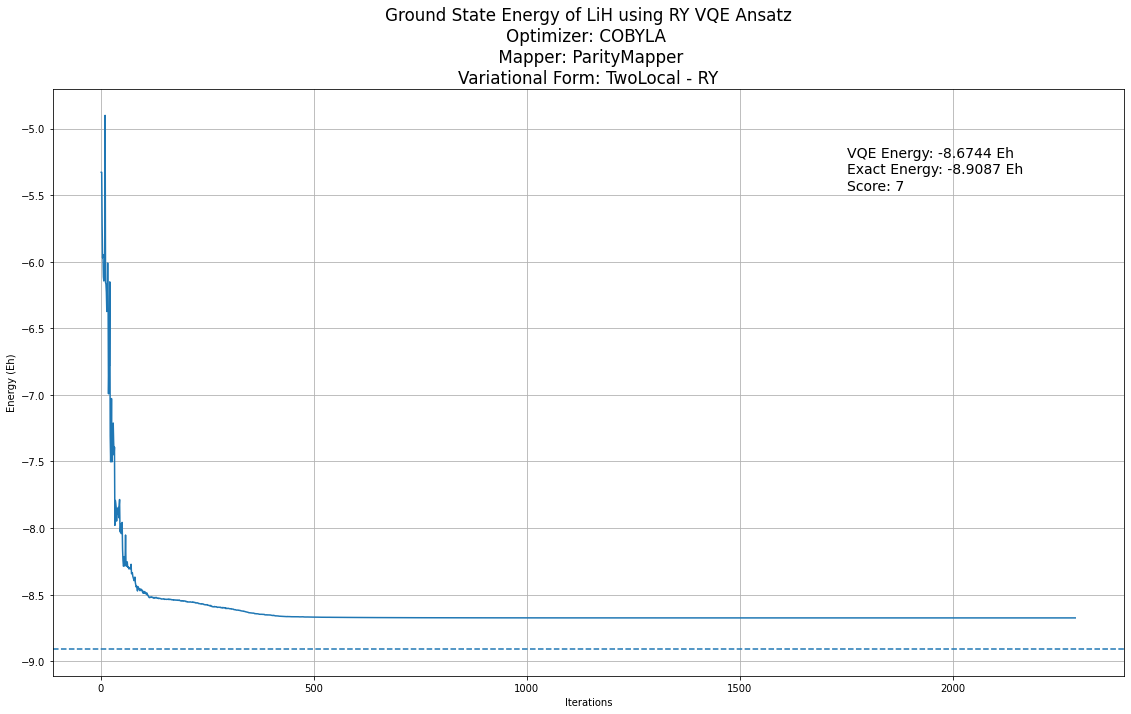

In [17]:
# Plotting the results

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))

plt.rc('font', size=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

# ax.set_facecolor("#293952")
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Eh)')
ax.grid()

fig.text(0.7, 0.75, f'VQE Energy: {result.optimal_value:.4f} Eh\nExact Energy: {exact_energy:.4f} Eh\nScore: {score:.0f}')

plt.title(f"Ground State Energy of LiH using RY VQE Ansatz\nOptimizer: {result_dict['optimizer']} \n Mapper: {result_dict['mapping']}\nVariational Form: {result_dict['ansatz']} - RY")

ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')

# fig_title = f"\
# {result_dict['optimizer']}-\
# {result_dict['mapping']}-\
# {result_dict['ansatz']}-\
# Energy({result_dict['energy (Ha)']:.3f})-\
# Score({result_dict['score']:.0f})\
# .png"

fig.savefig("ry_vqe_lih_fig", dpi=300)


# Displaying and saving the data

import pandas as pd

result_df = pd.DataFrame.from_dict([result_dict])
result_df[['optimizer','ansatz', '# of qubits', 'error (mHa)', 'pass', 'score','# of parameters','rotation blocks', 'entanglement_blocks',

    'entanglement', 'repetitions']]
